In [ ]:
# pip install pingouin

In [33]:
# import necessary packages

import pandas as pd
import itertools
import numpy as np
# import scipy.stats
from statsmodels.stats.weightstats import ztest as ztest
import time

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import networkx as nx
from random import randint

import math
# import pingouin as pg

In [17]:
# import necessary data

# result = pd.read_csv("/Users/robinkong/codes/result.csv")
# paperdata = pd.read_csv("/Users/robinkong/codes/paperdata.csv")
cb = pd.read_csv("/Users/robinkong/codes/citationBara.csv")
primdata = pd.read_csv("/Users/robinkong/codes/primdata.csv")
pair = pd.read_csv("/Users/robinkong/codes/pairs.csv", chunksize = 1000000)
# mfpairs = pd.read_csv("/Users/robinkong/codes/mfpairs.csv")
# sim_mf = pd.read_csv("/Users/robinkong/codes/mfpairs_similarity.csv")

In [3]:
# DataFrame: {citing_doi, citing_year, cited_doi}

citinfo = primdata[["doi", "year"]].drop_duplicates(subset = 'doi')
cols = ['citing_doi', 'citing_year', 'cited_doi']

citinfo = citinfo.merge(cb, left_on = 'doi', right_on = 'citing_doi',
              how = 'inner').drop(['doi'], axis=1).rename(
                  {'year': 'citing_year'}, axis=1).reindex(
                      columns=cols).sort_values('cited_doi')

citinfo.head()

,citing_doi,citing_year,cited_doi
120140,10.1103/PhysRev.2.109,1913,10.1103/PhysRev.1.124
123113,10.1103/PhysRev.40.281,1932,10.1103/PhysRev.1.124
120191,10.1103/PhysRev.21.250,1923,10.1103/PhysRev.1.124
144119,10.1103/PhysRev.8.738,1916,10.1103/PhysRev.1.124
2740023,10.1103/PhysRevSeriesI.2.1,1894,10.1103/PhysRev.1.2


# Basic Statistics

In [144]:
print("Total papers: ", result.doi.nunique())
print("Papers with gender info: ", paperdata.doi.nunique())
print("Papers with primary gender info: ", primdata.doi.nunique())

Total papers:  541448
Papers with gender info:  375738
Papers with primary gender info:  273020


In [145]:
# journal query condition

s = "PRL"

print(f"Total {s} papers: ", result[result['journal'] == s].doi.nunique())
print(f"{s} papers with gender info: ", paperdata[paperdata['journal'] == s].doi.nunique())

df = primdata[primdata['journal'] == s]

print(f"{s} papers with primary gender info: ", df.doi.nunique())
print(f"{s} papers written primarily by men: ", len(df[df['gender']=='male']))
print(f"{s} papers written primarily by women: ", len(df[df['gender']=='female']))

Total PRL papers:  110080
PRL papers with gender info:  76527
PRL papers with primary gender info:  54460
PRL papers written primarily by men:  48950
PRL papers written primarily by women:  5510


In [156]:
# PACS query condition

pacs = '90'

print(f"Total PACS{pacs} papers: ", result[result[f'pacs{pacs}'] == 1].doi.nunique())
print(f"PACS{pacs} papers with gender info: ", paperdata[paperdata[f'pacs{pacs}'] == 1].doi.nunique())

df = primdata[primdata[f'pacs{pacs}'] == 1]

print(f"PACS{pacs} papers with primary gender info: ", df.doi.nunique())
print(f"PACS{pacs} papers written primarily by men: ", len(df[df['gender']=='male']))
print(f"PACS{pacs} papers written primarily by women: ", len(df[df['gender']=='female']))

Total PACS90 papers:  26601
PACS90 papers with gender info:  12628
PACS90 papers with primary gender info:  9597
PACS90 papers written primarily by men:  8469
PACS90 papers written primarily by women:  1128


# Pair matching

## Preparing m-w similar pairs

In [18]:
# dealing with massive pair dataFrame

pair = list(pair)
mfpairs = pd.DataFrame(columns=list(pair[0].columns))

KeyboardInterrupt: 

In [33]:
# choosing pairs where one primary author is woman and the other is man

for p in tqdm(pair):
    mfpairs = pd.concat([mfpairs, p[p['gender1'] != p['gender2']]])

100%|██████████| 69/69 [31:34<00:00, 27.46s/it]


In [58]:
mfpairs = mfpairs.drop_duplicates().reset_index(drop=True)
print(len(mfpairs))

mfpairs.to_csv(f'/Users/robinkong/codes/mfpairs.csv',index=False)

14490273


In [59]:
len(mfpairs[mfpairs['qval']<0.002])/len(mfpairs)

0.10173576439864176

## Preparing m-m similar pairs

In [19]:
# dealing with massive pair dataFrame

pair = list(pair)
mmpairs = pd.DataFrame(columns=list(pair[0].columns))

In [ ]:
# choosing pairs where both primary authors are men

for p in tqdm(pair):
    mmpairs = pd.concat([mmpairs, p[(p.gender1 == 'male') & (p.gender2 == 'male')]])

 54%|█████▎    | 37/69 [37:59<1:12:04, 135.13s/it]

In [ ]:
mmpairs = mmpairs.drop_duplicates().reset_index(drop=True)
print(len(mmpairs))

mmpairs.to_csv(f'/Users/robinkong/codes/mmpairs.csv',index=False)

## Preparing w-w similar pairs

In [5]:
# dealing with massive pair dataFrame

pair = list(pair)
wwpairs = pd.DataFrame(columns=list(pair[0].columns))

In [7]:
# choosing pairs where both primary authors are men

for p in tqdm(pair):
    wwpairs = pd.concat([wwpairs, p[(p.gender1 == 'female') & (p.gender2 == 'female')]])

100%|██████████| 65/65 [01:20<00:00,  1.24s/it]


In [8]:
wwpairs = wwpairs.drop_duplicates().reset_index(drop=True)
print(len(wwpairs))

wwpairs.to_csv(f'/Users/robinkong/codes/wwpairs.csv',index=False)

1039037


## Counting for each similar pair (m-w pairs)

In [5]:
sim_mf = mfpairs[['paper1', 'paper2', 'gender1', 'gender2', 'year1', 'year2', 'keyval', 'qval']]

In [ ]:
# Create a dummy data (test1, test2) to perform SQL:
# Create a DataFrame that treats citation info for male and female papers
test1 = sim_mf.merge(citinfo, left_on = 'paper1',
                    right_on = 'cited_doi', how = 'left').drop(
                        ["cited_doi", "citing_year"], axis=1).drop_duplicates(
                            subset=['paper1', 'citing_doi'])
test1['count'] = test1.groupby(['paper1'])['paper1'].transform('count')
test1 = test1.drop(["citing_doi"], axis=1).rename({'count': 'count1'}, axis=1)

test1 = test1.drop_duplicates(subset=['paper1', 'paper2'])[['paper1', 'count1']]
sim_mf = sim_mf.merge(test1, on='paper1', how='inner')

test2 = sim_mf.merge(citinfo, left_on = 'paper2',
                    right_on = 'cited_doi', how = 'left').drop(
                        ["cited_doi", "citing_year"], axis=1).drop_duplicates(
                            subset=['paper2', 'citing_doi'])
test2['count'] = test2.groupby(['paper2'])['paper2'].transform('count')
test2 = test2.drop(["citing_doi"], axis=1).rename(
    {'count': 'count2'}, axis=1).drop_duplicates(
        subset=['paper1', 'paper2'])[['paper2', 'count2']]
sim_mf = sim_mf.merge(test2, on='paper2', how='inner')

# Delete the dummy data
del test1
del test2

In [22]:
# Calculate year & centrality difference among pairs

listd = []
listy = []

for c in range(len(sim_mf)):
    if sim_mf['gender1'][c] == 'male':
        listd.append(sim_mf['count1'][c] - sim_mf['count2'][c])
        listy.append(sim_mf['year1'][c] - sim_mf['year2'][c])
    else:
        listd.append(sim_mf['count2'][c] - sim_mf['count1'][c])
        listy.append(sim_mf['year2'][c] - sim_mf['year1'][c])

sim_mf['countd'] = listd
sim_mf['yeard'] = listy

# Keep the minimum q-value per pair
sim_mf = sim_mf.sort_values('qval').drop_duplicates(
    subset=['paper1', 'paper2'], keep='first')

100%|██████████| 14490273/14490273 [10:25<00:00, 23159.47it/s]


In [38]:
sim_mf.to_csv("/Users/robinkong/codes/mfpairs_similarity.csv", index=False)

## Counting for each similar pair (w-w pairs)

In [10]:
sim_ww = wwpairs[['paper1', 'paper2', 'gender1', 'gender2', 'year1', 'year2', 'keyval', 'qval']]

In [11]:
# Create a dummy data (test1, test2) to perform SQL:
# Create a DataFrame that treats citation info for male and female papers
test1 = sim_ww.merge(citinfo, left_on = 'paper1',
                    right_on = 'cited_doi', how = 'left').drop(
                        ["cited_doi", "citing_year"], axis=1).drop_duplicates(
                            subset=['paper1', 'citing_doi'])
test1['count'] = test1.groupby(['paper1'])['paper1'].transform('count')
test1 = test1.drop(["citing_doi"], axis=1).rename({'count': 'count1'}, axis=1)

test1 = test1.drop_duplicates(subset=['paper1', 'paper2'])[['paper1', 'count1']]
sim_ww = sim_ww.merge(test1, on='paper1', how='inner')

test2 = sim_ww.merge(citinfo, left_on = 'paper2',
                    right_on = 'cited_doi', how = 'left').drop(
                        ["cited_doi", "citing_year"], axis=1).drop_duplicates(
                            subset=['paper2', 'citing_doi'])
test2['count'] = test2.groupby(['paper2'])['paper2'].transform('count')
test2 = test2.drop(["citing_doi"], axis=1).rename(
    {'count': 'count2'}, axis=1).drop_duplicates(
        subset=['paper1', 'paper2'])[['paper2', 'count2']]
sim_ww = sim_ww.merge(test2, on='paper2', how='inner')

# Delete the dummy data
del test1
del test2

In [13]:
# Calculate year & centrality difference among pairs

listd = []
listy = []

for c in tqdm(range(len(sim_ww))):
    if sim_ww['gender1'][c] == 'male':
        listd.append(sim_ww['count1'][c] - sim_ww['count2'][c])
        listy.append(sim_ww['year1'][c] - sim_ww['year2'][c])
    else:
        listd.append(sim_ww['count2'][c] - sim_ww['count1'][c])
        listy.append(sim_ww['year2'][c] - sim_ww['year1'][c])

sim_ww['countd'] = listd
sim_ww['yeard'] = listy

# Keep the minimum q-value per pair
sim_ww = sim_ww.sort_values('qval').drop_duplicates(
    subset=['paper1', 'paper2'], keep='first')

100%|██████████| 1039037/1039037 [00:40<00:00, 25500.71it/s]


In [15]:
sim_ww.to_csv("/Users/robinkong/codes/wwpairs_similarity.csv", index=False)

# Similarity Analysis

In [76]:
# filter conditions

# sdoi = primdata[primdata['journal'] == "PRL"].doi
# sdoi = primdata[primdata['pacs90'] == 1].doi

df = sim_mf.copy()

# df = df[df['paper1'].isin(sdoi)]
# df = df[df['paper2'].isin(sdoi)].reset_index(drop=True)

In [ ]:
# filter year constraints

N = 3

df = df[df['yeard'] >= -N]
df = df[df['yeard'] <= N].reset_index(drop=True)

In [77]:
p = 0.001
df_vld = df[df['qval'] < p]

print("N: ", len(df))
print("M: ", len(df_vld))
print("M/N: ", len(df_vld)/len(df))

N:  2730100
M:  410418
M/N:  0.15033075711512398


In [78]:
# getting mlist and fmlist (count per gender)

mlist = []
fmlist = []

for i in tqdm(range(len(df_vld))):
    if df_vld['gender1'][i] == 'male':
        mlist.append(df_vld['count1'][i])
        fmlist.append(df_vld['count2'][i])
    else:
        mlist.append(df_vld['count2'][i])
        fmlist.append(df_vld['count1'][i])

# Find z-scores (for p-values)
ztest(mlist, fmlist, value=0)

100%|██████████| 410418/410418 [00:04<00:00, 95449.02it/s]


(19.150151095942956, 9.65063481804804e-82)

In [ ]:
# Find z-scores (for p-values)
print(ztest(mlist, fmlist, value=0))
print('')

# Find effect size
print(pg.compute_effsize(mlist, fmlist, paired=True, eftype='hedges'))

# Centrality Difference Trend by Year (m-f pairs)

In [36]:
sim_mf = pd.read_csv("/Users/robinkong/codes/mfpairs_similarity.csv")
sim_mf.head()

,paper1,paper2,gender1,gender2,year1,year2,keyval,qval,count1,count2,countd,yeard
0,10.1103/PhysRevB.74.035411,10.1103/PhysRevB.75.205440,female,male,2006,2007,4,-1.117244e-10,1,1,0,1
1,10.1103/PhysRevB.73.075112,10.1103/PhysRevB.74.045113,female,male,2006,2006,4,-1.117173e-10,9,2,-7,0
2,10.1103/PhysRev.88.1109,10.1103/RevModPhys.24.321,male,female,1952,1952,2,-9.355250e-11,45,79,-34,0
3,10.1103/PhysRevE.70.011103,10.1103/PhysRevE.70.056128,male,female,2004,2004,3,-8.545054e-11,1,1,0,0
4,10.1103/PhysRevB.76.174508,10.1103/PhysRevLett.99.087001,male,female,2007,2007,3,-8.545054e-11,1,3,-2,0


In [37]:
mfs = sim_mf[sim_mf['yeard'] <= 3]
mfs = mfs[mfs['yeard'] >= -3].reset_index(drop=True)

lateryear = []

for i in tqdm(range(len(mfs))):
    lateryear.append(max(mfs['year1'][i], mfs['year2'][i]))

mfs['lateryear'] = lateryear

mfs.head()

100%|██████████| 5611686/5611686 [00:35<00:00, 158203.68it/s]


,paper1,paper2,gender1,gender2,year1,year2,keyval,qval,count1,count2,countd,yeard,lateryear
0,10.1103/PhysRevB.74.035411,10.1103/PhysRevB.75.205440,female,male,2006,2007,4,-1.117244e-10,1,1,0,1,2007
1,10.1103/PhysRevB.73.075112,10.1103/PhysRevB.74.045113,female,male,2006,2006,4,-1.117173e-10,9,2,-7,0,2006
2,10.1103/PhysRev.88.1109,10.1103/RevModPhys.24.321,male,female,1952,1952,2,-9.355250e-11,45,79,-34,0,1952
3,10.1103/PhysRevE.70.011103,10.1103/PhysRevE.70.056128,male,female,2004,2004,3,-8.545054e-11,1,1,0,0,2004
4,10.1103/PhysRevB.76.174508,10.1103/PhysRevLett.99.087001,male,female,2007,2007,3,-8.545054e-11,1,3,-2,0,2007


In [38]:
p = 0.001

simp = mfs[mfs['qval'] < p].sort_values('countd').reset_index(drop=True)
print(len(simp)/len(mfs))

0.10213864425058708


In [39]:
simp = simp[['lateryear', 'countd']].sort_values(by=['lateryear', 'countd'])

print(len(simp))
simp.head()

573170


,lateryear,countd
214976,1903,-1
217369,1903,-1
303830,1903,0
474746,1916,6
354486,1918,1


In [40]:
simp = simp.groupby(['lateryear'])['lateryear'].count()
simp.head()

lateryear
1903    3
1916    1
1918    1
1921    1
1923    2
Name: lateryear, dtype: int64

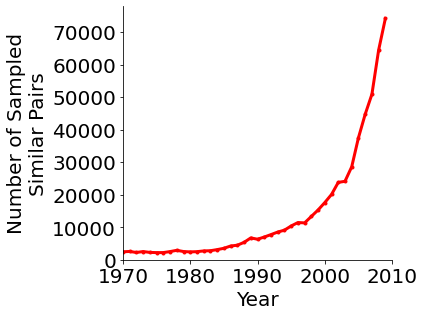

In [41]:
fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

simp.plot(style='.-',color='red', lw=3)

plt.xlabel('Year', fontsize=20)
plt.xlim(xmin=1970, xmax=2010)
plt.xticks(np.arange(1970, 2011, 10), fontsize=20)
plt.ylabel('Number of Sampled\nSimilar Pairs', fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(ymin=0)

plt.tight_layout()
# fig.savefig(f"drive/My Drive/codes/SI_fig7.pdf")